In [1]:
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from torch.distributions.utils import logits_to_probs

from sklearn import linear_model
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam

from src.utils import load_data

### Load data

In [2]:
X, y, k = load_data()
print(X.head())
X = X.values
y = y.values
print('X-shape: {}, y-shape: {}'.format(X.shape, y.shape)) 

   youth_pop_5to18  commute_priv_vehicle  med_hhincome  avg_ann_daily_traffic  \
0              894              0.634634         74837                 8682.0   
1             1158              0.494977         77991                16917.0   
2             1120              0.422405         32354                22712.0   
3              281              0.199795         34635               124767.0   
4             1998              0.286795         23423                10219.0   

   fragment_index  TotalPop   Men  Women  Hispanic  White  ...  Transit  Walk  \
0       -3.061385      5403  2659   2744      75.8    2.3  ...     38.6   2.9   
1       -2.915361      5915  2896   3019      62.7    3.6  ...     44.6   1.4   
2       -0.227456      5879  2558   3321      65.1    1.6  ...     45.5   8.6   
3        3.029461      2591  1206   1385      55.4    9.0  ...     63.9   3.0   
4        0.165237      8516  3301   5215      61.1    1.6  ...     68.2   4.3   

   OtherTransp  WorkAtHome

##### Prepare data for model.

In [3]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

##### Baseline linear regression

In [4]:
# Get indeces for dividing data into training and test set.
train_perc = 0.8 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]

In [5]:
X_train = X[ix_train,:]
X_test = X[ix_test,:]
k_train = k[ix_train]
k_test = k[ix_test]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 1676
num test: 419


In [6]:
# create and fit regression model
lreg = linear_model.LinearRegression()
lreg.fit(X_train, y_train)

# make predictions for test set
y_hat_lreg = lreg.predict(X_test)
print("first 5 predictions:", y_hat_lreg[:5])
print("first 5 true values:", y_test[:5])

# evaluate prediction accuracy
print("MSE:", sum((y_hat_lreg - y_test)**2)/len(y_hat_lreg))

first 5 predictions: [6.33504849 4.73467556 7.08052089 8.69541566 5.6513755 ]
first 5 true values: [ 4  1  1 19  2]
MSE: 45.92238836135486


In [7]:
# Test significance in our fit.
import statsmodels.api as sm

X2 = sm.add_constant(X_train)
ols = sm.OLS(y_train, X2)
ols = ols.fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     25.47
Date:                Mon, 24 May 2021   Prob (F-statistic):          9.81e-126
Time:                        17:01:41   Log-Likelihood:                -5355.6
No. Observations:                1676   AIC:                         1.078e+04
Df Residuals:                    1641   BIC:                         1.097e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1510      0.146     55.776      0.0

So only a very few number of parameters are significant. The model is heavily driven by bias and x1.

Therefore, we assume that not all variables will be relevant to include in our hierarchical model. Therefore, we are only interested in keeping a number of the variables.
Let's try only keeping 8 features based on Least Angle Regression Selection (LARS):

In [8]:
from sklearn import linear_model

lars = linear_model.Lars(n_nonzero_coefs=8)
lars.fit(X_train, y_train)
x_include = lars.coef_ != 0
x_include = np.array([i for i, incl in enumerate(x_include) if incl])
print("Include ids: ", x_include)

Include ids:  [ 0  1  2  9 10 16 19 25]


In [9]:
X2 = sm.add_constant(X_train[:, x_include])
ols2 = sm.OLS(y_train, X2)
ols2 = ols2.fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     105.3
Date:                Mon, 24 May 2021   Prob (F-statistic):          3.15e-142
Time:                        17:01:41   Log-Likelihood:                -5368.0
No. Observations:                1676   AIC:                         1.075e+04
Df Residuals:                    1667   BIC:                         1.080e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1547      0.146     55.912      0.0

Notice that all variables might not still be significant, but this might change based on the train/test split. On could also use forward or backward feature selection for this matter.

In [10]:
# create and fit regression model
lreg = linear_model.LinearRegression()
lreg.fit(X_train[:, x_include], y_train)

# make predictions for test set
y_hat_lreg = lreg.predict(X_test[:, x_include])
print("first 5 predictions:", y_hat_lreg[:5])
print("first 5 true values:", y_test[:5])

# evaluate prediction accuracy
print("MSE:", sum((y_hat_lreg - y_test)**2)/len(y_hat_lreg))

first 5 predictions: [6.16584197 5.1605003  6.7812672  8.4053331  6.09431054]
first 5 true values: [ 4  1  1 19  2]
MSE: 46.130953052444845


### Redefine used variables

In [11]:
X_train = X_train[:, x_include]
X_test = X_test[:, x_include]

### Define model

**Generative Process**
<ol>
    <li> Draw parameter $r \sim \text{Gamma}(\alpha, \beta)$ . </li>
    <li> Draw parameter $\sigma \sim \text{HalfCauchy}(1)$. </li>
    <li> For each group $k \in \{1, \dots, K\}$ </li>
    <ol>
        <li> Draw linear coefficients $\beta_k \sim N(\beta|\bf{\mu_\beta},\bf{\sigma_\beta}\textbf{I})$</li>
    </ol>
    <li> For the n'th observation </li>
    <ol>
        <li> Draw $\psi_n \sim N(\psi_n | \beta_{k_n}^T\textbf{X}'_n+f_{\text{nnet}}(\textbf{X}^*_n), \sigma^2)$</li>
     OR Draw $\psi_n \sim N(\psi_n | \beta_{k_n}^T\textbf{X}'_n, \sigma^2)$</li>
        <li> Compute $p_n$. </li>
        <li> Draw $y_n \sim \text{NB}(r, p_n)$</li>
    </ol>
</ol>

We could also try to fit an $r_k$ for each group.


In [12]:
def hierarchical_model(X, k, n_k, obs=None):
    
    # Number of observations
    N, n_feat = X.shape
    
    # Hyperparameters
    r_gamma1 = 2
    r_gamma2 = 2
    beta_mu = 0
    beta_sigma = 1
    sigma_gamma = 1

    # Draw parameters.
    r = pyro.sample("r", dist.Gamma(r_gamma1, r_gamma2))
    sigma = pyro.sample("sigma", dist.HalfCauchy(sigma_gamma))
    
    with pyro.plate("group", n_k):
        # Draw the parameters for each group
        beta = pyro.sample(
            "beta",
            dist.Normal(beta_mu*torch.ones(n_feat), beta_sigma*torch.ones(n_feat)).to_event()
        )
        
    with pyro.plate("observations", N):
        psi_mu = torch.matmul(X, beta[k].transpose(0,1)).diag()
        psi = pyro.sample("psi", dist.Normal(psi_mu, sigma))
        pred = pyro.sample(
            "pred",
            dist.NegativeBinomial(r, logits=psi),
            obs=obs
        )
    
    return pred

In [13]:
# Prepare data for Pyro model
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
k_train = torch.tensor(k_train).long() # these are indices, therefore they need to be (long) integers
n_k = len(np.unique(k))

In [14]:
%%time

# Define guide function.
guide = AutoDiagonalNormal(hierarchical_model)

# Reset parameter values.
pyro.clear_param_store()

# Define the number of optimization steps.
n_steps = 2000

# Setup the optimizer.
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm.
elbo = Trace_ELBO(num_particles=1)
svi = SVI(hierarchical_model, guide, optimizer, loss=elbo)

# Do gradient steps.
t = tqdm(range(n_steps))
for step in t:
    elbo = svi.step(X_train, k_train, n_k, y_train)
    
    # display the epoch training loss
    t.set_description("{:d} ELBO: {:.1f}".format(step, elbo))
    t.refresh() # to show immediately the update

1999 ELBO: 5073.5: 100%|███████████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 61.26it/s]

Wall time: 32.7 s


##### Visualizations of variable differences from county to county

In [15]:
from pyro.infer import Predictive

predictive = Predictive(hierarchical_model, guide=guide, num_samples=10000,
                        return_sites=("beta", "r", "pred", "sigma"))
samples = predictive(X_train, k_train, n_k, y_train)

In [16]:
beta_samples = samples["beta"].detach().numpy()
r_samples = samples["r"].detach().numpy()
preds_samples = samples["pred"].detach().numpy()
sigma_samples = samples["sigma"].detach().numpy()

C:\Users\niels\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\niels\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\niels\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

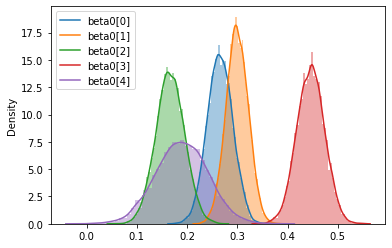

In [17]:
beta_index = 0

for k_ in range(n_k):
    sns.distplot(beta_samples[:,k_,beta_index])
plt.legend(["beta0[%d]" % c for c in range(n_k)])
plt.show()

##### MSE for model

In [18]:
beta = beta_samples.mean(axis=0)
r = r_samples.mean(axis=0)
psi = (beta[k_test] @ X_test.T).diagonal()
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean)
# evaluate prediction accuracy
print("MSE:", sum((y_hat - y_test)**2)/len(y_hat))

MSE: 52.031116778841


<ipython-input-18-3c37a49959df>:4: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))


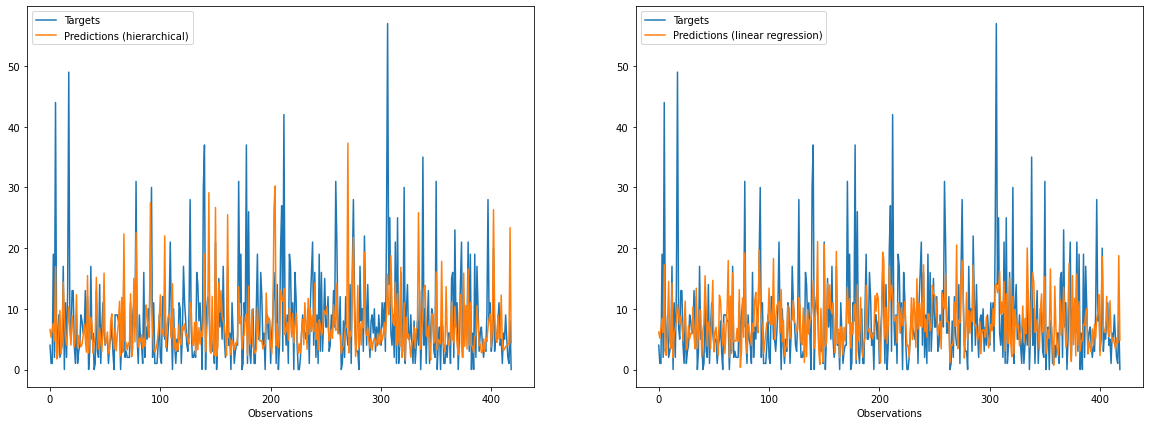

In [19]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].plot(y_test, label="Targets")
ax[0].plot(y_hat, label="Predictions (hierarchical)")
ax[0].legend()
ax[0].set_xlabel("Observations")

ax[1].plot(y_test, label="Targets")
ax[1].plot(y_hat_lreg, label="Predictions (linear regression)")
ax[1].legend()
ax[1].set_xlabel("Observations")
plt.show()

[]

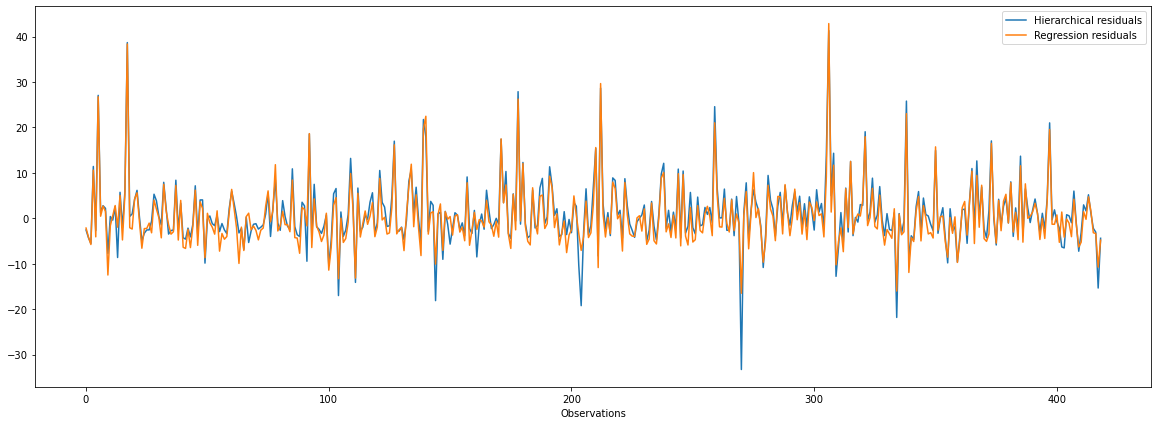

In [20]:
fig, ax = plt.subplots(1,1, figsize=(20,7))

ax.plot(y_test-y_hat, label="Hierarchical residuals")
ax.plot(y_test-y_hat_lreg, label="Regression residuals")
ax.legend()
ax.set_xlabel("Observations")
plt.plot()

## Try adding Neural Network to hierarchical model

In [21]:
from torch import nn

class NN(nn.Module):
    """An artificial neural network."""
    
    def __init__(self, input_shape, output_dim):
        super(NN, self).__init__()
        
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.observation_features = np.prod(input_shape)

        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=4),
            nn.LeakyReLU(),
            nn.Linear(in_features=4, out_features=4),
            nn.Tanh(),
            nn.Linear(in_features=4, out_features=output_dim)
        )
        
    def forward(self, x):
        """Run encoder."""
        
        # Latent space
        x = self.encoder(x)

        return x


def hierarchical_nn_model(X, k, n_k, obs=None):
    # Number of observations
    N, n_feat = X.shape
    
    # Hyperparameters
    r_gamma1 = 2
    r_gamma2 = 2
    beta_mu = 0
    beta_sigma = 1
    sigma_gamma = 1

    # Draw parameters.
    r = pyro.sample("r", dist.Gamma(r_gamma1, r_gamma2).to_event())
    sigma = pyro.sample("sigma", dist.HalfCauchy(sigma_gamma).to_event())
    
    torch_model = NN(input_shape=n_feat, output_dim=1) 
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {}
    for name, par in torch_model.named_parameters():
        # Each parameter has a N(0, 1) prior
        priors[name] = dist.Normal(torch.zeros(*par.shape), torch.ones(*par.shape)).independent(1)
    
    bayesian_model = pyro.random_module("bayesian_model", torch_model, priors) # Make this model and these priors a Pyro model
    sampled_model = bayesian_model()                                           # Initialize the nn model
    
    with pyro.plate("group", n_k):
        # Draw the parameters for each group
        beta = pyro.sample(
            "beta",
            dist.Normal(beta_mu*torch.ones(n_feat), beta_sigma*torch.ones(n_feat)).to_event()
        )
    
    with pyro.plate("data", N):
        # Draw for observations.
        nn_out = sampled_model(X).squeeze(-1) # Feed-forward the design matrix X through the neural network
        lin_contr = torch.matmul(X, beta[k].transpose(0,1)).diag()
        psi_mu = lin_contr + nn_out
        
        psi = pyro.sample("psi", dist.Normal(psi_mu, sigma))
        pred = pyro.sample(
            "pred",
            dist.NegativeBinomial(r, logits=psi),
            obs=obs
        )
    
    return pred

In [22]:
%%time

# Define guide function.
nn_guide = AutoDiagonalNormal(hierarchical_nn_model)

# Reset parameter values.
pyro.clear_param_store()

# Define the number of optimization steps.
n_steps = 1500

# Setup the optimizer.
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm.
elbo = Trace_ELBO(num_particles=3)
svi = SVI(hierarchical_nn_model, nn_guide, optimizer, loss=elbo)

# Do gradient steps.
t = tqdm(range(n_steps))
for step in t:
    elbo = svi.step(X_train, k_train, n_k, y_train)
    
    # display the epoch training loss
    t.set_description("{:d} ELBO: {:.1f}".format(step, elbo))
    t.refresh() # to show immediately the update

  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]C:\Users\niels\anaconda3\lib\site-packages\pyro\primitives.py:404: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn("The `random_module` primitive is deprecated, and will be removed "
1499 ELBO: 5088.1: 100%|███████████████████████████████████████████████████████████| 1500/1500 [01:23<00:00, 17.90it/s]

Wall time: 1min 23s


#### Predict with the model

In [23]:
predictive = Predictive(hierarchical_nn_model, guide=nn_guide, num_samples=5000,
                        return_sites=())
samples = predictive(X_train, k_train, n_k, y_train)

In [24]:
nn_pred = NN(input_shape=X_test.shape[1], output_dim=1) 

In [25]:
# Extract samples
beta_samples = samples["beta"].detach().numpy()
r_samples = samples["r"].detach().numpy()
preds_samples = samples["pred"].detach().numpy()
sigma_samples = samples["sigma"].detach().numpy()

weight0_samples = samples['bayesian_model$$$encoder.0.weight'].detach().numpy()
bias0_samples = samples['bayesian_model$$$encoder.0.bias'].detach().numpy()

weight2_samples = samples['bayesian_model$$$encoder.2.weight'].detach().numpy()
bias2_samples = samples['bayesian_model$$$encoder.2.bias'].detach().numpy()

weight4_samples = samples['bayesian_model$$$encoder.4.weight'].detach().numpy()
bias4_samples = samples['bayesian_model$$$encoder.4.bias'].detach().numpy()

In [26]:
weight0 = weight0_samples.mean(axis=0)
bias0 = bias0_samples.mean(axis=0)

weight2 = weight2_samples.mean(axis=0)
bias2 = bias2_samples.mean(axis=0)

weight4 = weight4_samples.mean(axis=0)
bias4 = bias4_samples.mean(axis=0)

parameter_estimates = [weight0, bias0, weight2, bias2, weight4, bias4]

In [27]:
# Update network parameters.
for named_params, par_est in zip(nn_pred.named_parameters(), parameter_estimates):
    _, par = named_params
    par = par_est

In [31]:
beta = beta_samples.mean(axis=0)
r = r_samples.mean(axis=0)
psi = (beta[k_test] @ X_test.T).diagonal() + nn_pred(torch.Tensor(X_test)).detach().numpy().ravel()
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean)
# evaluate prediction accuracy
print("MSE:", sum((y_hat - y_test)**2)/len(y_hat))

MSE: 52.03148284886097


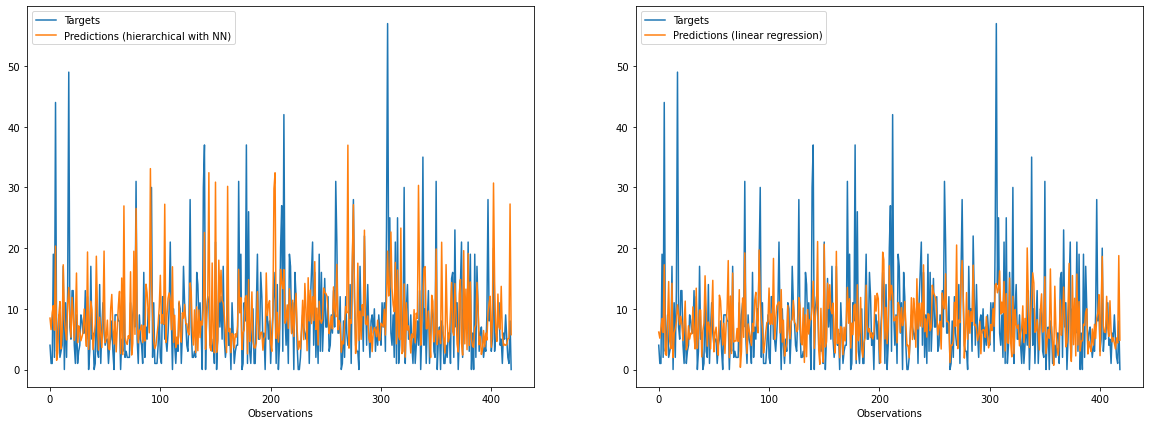

In [32]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].plot(y_test, label="Targets")
ax[0].plot(y_hat, label="Predictions (hierarchical with NN)")
ax[0].legend()
ax[0].set_xlabel("Observations")

ax[1].plot(y_test, label="Targets")
ax[1].plot(y_hat_lreg, label="Predictions (linear regression)")
ax[1].legend()
ax[1].set_xlabel("Observations")
plt.show()

[]

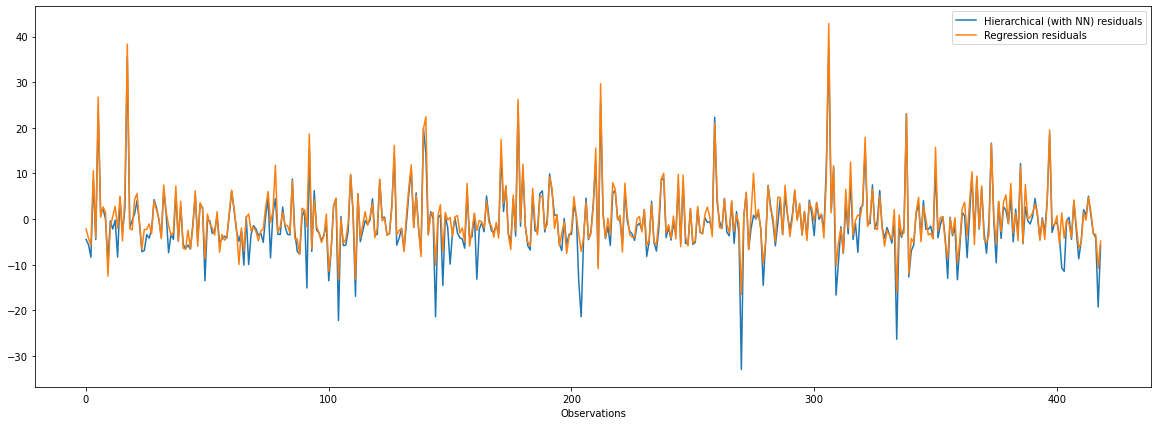

In [33]:
fig, ax = plt.subplots(1,1, figsize=(20,7))

ax.plot(y_test-y_hat, label="Hierarchical (with NN) residuals")
ax.plot(y_test-y_hat_lreg, label="Regression residuals")
ax.legend()
ax.set_xlabel("Observations")
plt.plot()